# EV Vehicle Charging Demand Prediction  

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn

## Import Required Libraries

In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Load the Dataset

In [2]:
df=pd.read_csv("Dataset.csv")

In [3]:
df.head()

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,September 30 2022,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,December 31 2022,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,January 31 2020,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,June 30 2022,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,July 31 2021,Douglas,CO,Passenger,0,1,1,83,84,1.19


## Initial Data Exploration

In [4]:
print("Number of rows and columns:",df.shape)

Number of rows and columns: (20819, 10)


In [5]:
print("Data Types and Memory:")
print(df.info())

Data Types and Memory:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20819 entries, 0 to 20818
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date                                      20819 non-null  object 
 1   County                                    20733 non-null  object 
 2   State                                     20733 non-null  object 
 3   Vehicle Primary Use                       20819 non-null  object 
 4   Battery Electric Vehicles (BEVs)          20819 non-null  object 
 5   Plug-In Hybrid Electric Vehicles (PHEVs)  20819 non-null  object 
 6   Electric Vehicle (EV) Total               20819 non-null  object 
 7   Non-Electric Vehicle Total                20819 non-null  object 
 8   Total Vehicles                            20819 non-null  object 
 9   Percent Electric Vehicles                 20819 non-null  float64
dtypes: float64(

In [6]:
df.columns

Index(['Date', 'County', 'State', 'Vehicle Primary Use',
       'Battery Electric Vehicles (BEVs)',
       'Plug-In Hybrid Electric Vehicles (PHEVs)',
       'Electric Vehicle (EV) Total', 'Non-Electric Vehicle Total',
       'Total Vehicles', 'Percent Electric Vehicles'],
      dtype='object')

In [7]:
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
Date                                         0
County                                      86
State                                       86
Vehicle Primary Use                          0
Battery Electric Vehicles (BEVs)             0
Plug-In Hybrid Electric Vehicles (PHEVs)     0
Electric Vehicle (EV) Total                  0
Non-Electric Vehicle Total                   0
Total Vehicles                               0
Percent Electric Vehicles                    0
dtype: int64


Identify outliers in 'Percent Electric Vehicles' using the IQR method to detect values beyond typical distribution range.

In [8]:
#Calculate Q1,Q3 and IQR
Q1=df['Percent Electric Vehicles'].quantile(0.25)
Q3=df['Percent Electric Vehicles'].quantile(0.75)
IQR=Q3-Q1

#Define the lower and upper bounds for acceptable range
lower_bound=Q1-1.5*IQR
upper_bound=Q3+1.5*IQR

print('Lower Bound:',lower_bound)
print('Upper Bound:',upper_bound)

#Identify rows where 'Percent Electric Vehicles' is outside the IQR bounds
outliers=df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Number of outliers in 'Percent Electric Vehicles':",outliers.shape[0])

Lower Bound: -3.5174999999999996
Upper Bound: 6.9025
Number of outliers in 'Percent Electric Vehicles': 2476


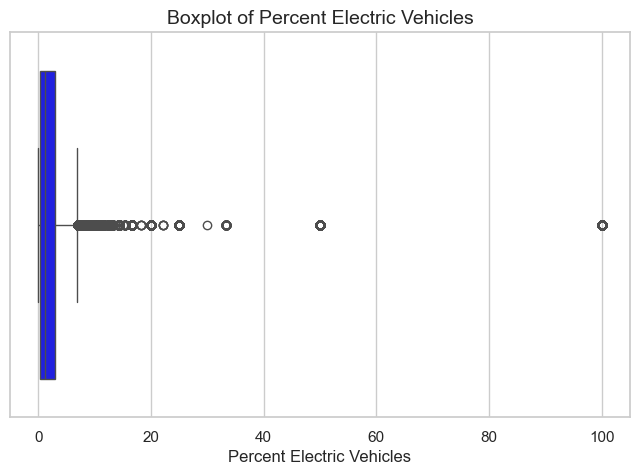

In [9]:
#Set figure size and style
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")

#Create boxplot for 'Percent Electric Vehicles'
sns.boxplot(x=df['Percent Electric Vehicles'],color='blue')

#Add title and labels
plt.title("Boxplot of Percent Electric Vehicles",fontsize=14)
plt.xlabel("Percent Electric Vehicles",fontsize=12)

#Display the plot
plt.show()


## DATA PREPROCESSING

**Data Cleaning**

In [10]:
# Convert 'Date' to datetime; invalid entries become NaT
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows with invalid or missing 'Date'
df = df[df['Date'].notnull()]

# Drop rows with missing EV total values
df = df[df['Electric Vehicle (EV) Total'].notnull()]

# Fill missing 'County' and 'State' with 'Unknown'
df['County'] = df['County'].fillna('Unknown')
df['State'] = df['State'].fillna('Unknown')

# Check for any remaining nulls
print("Missing Vvalues after the fill:")
print(df[['County', 'State']].isnull().sum())

# Show first few cleaned rows
df.head()


Missing Vvalues after the fill:
County    0
State     0
dtype: int64


,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,2022-09-30,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,2022-12-31,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,2020-01-31,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,2022-06-30,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,2021-07-31,Douglas,CO,Passenger,0,1,1,83,84,1.19


Remove Outliers from 'Percent Electric Vehicles' column: By capping the values to the IQR bounds

In [11]:
# Cap the outliers - it keeps all the data while reducing the skew from extreme values.

df['Percent Electric Vehicles'] = np.where(df['Percent Electric Vehicles'] > upper_bound, upper_bound,
                                 np.where(df['Percent Electric Vehicles'] < lower_bound, lower_bound, df['Percent Electric Vehicles']))

# Identify outliers after capping
outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Number of outliers in 'Percent Electric Vehicles':", outliers.shape[0])

Number of outliers in 'Percent Electric Vehicles': 0


Converting all the count columns to numeric (in case they are strings)

In [12]:
cols_to_convert = [
    'Battery Electric Vehicles (BEVs)',
    'Plug-In Hybrid Electric Vehicles (PHEVs)',
    'Electric Vehicle (EV) Total',
    'Non-Electric Vehicle Total',
    'Total Vehicles',
    'Percent Electric Vehicles'
]

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df[cols_to_convert].describe()

,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
count,20266.000000,20468.000000,20119.000000,13983.000000,13979.000000,20819.000000
mean,25.855176,21.790942,31.623093,132.845312,134.463767,2.122378
std,102.004224,92.309729,115.742017,174.033916,174.448753,2.277542
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,1.000000,26.000000,27.000000,0.390000
50%,1.000000,1.000000,1.000000,69.000000,70.000000,1.220000
75%,2.000000,1.000000,3.000000,167.000000,169.000000,2.995000
max,999.000000,999.000000,999.000000,999.000000,998.000000,6.902500


Identifying counties with most number of EVs

In [13]:
# Identify counties with the highest and lowest total electric vehicles
top_counties = df.groupby('County')['Electric Vehicle (EV) Total'].sum().sort_values(ascending=False).head(3)
bottom_counties = df.groupby('County')['Electric Vehicle (EV) Total'].sum().sort_values().head(3)

print("Top 3 Counties by EV Total:\n", top_counties)
print("\nBottom 3 Counties by EV Total:\n", bottom_counties)


Top 3 Counties by EV Total:
 County
Clallam      39839.0
Jefferson    39683.0
San Juan     39309.0
Name: Electric Vehicle (EV) Total, dtype: float64

Bottom 3 Counties by EV Total:
 County
Brown         1.0
Union         1.0
Hood River    1.0
Name: Electric Vehicle (EV) Total, dtype: float64


Total number of vehicles across different categories

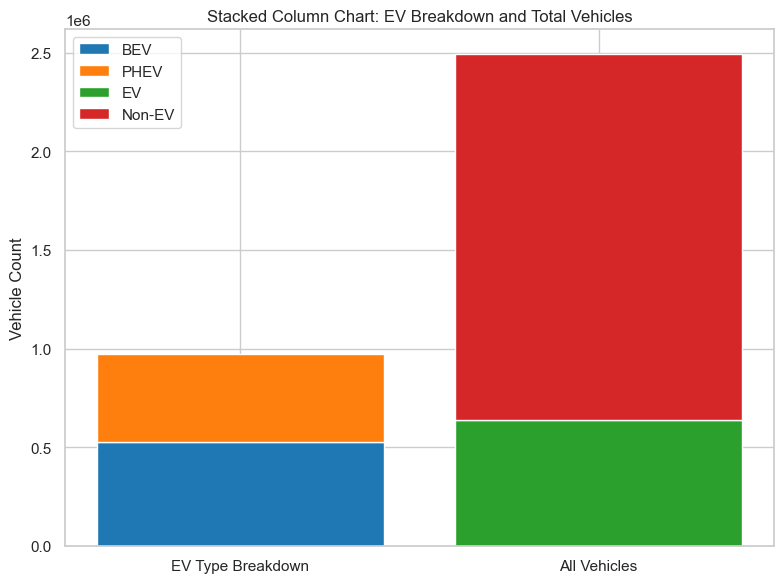

In [14]:
# Total sums for stacked column chart
bev_total = df['Battery Electric Vehicles (BEVs)'].sum()
phev_total = df['Plug-In Hybrid Electric Vehicles (PHEVs)'].sum()
ev_total = df['Electric Vehicle (EV) Total'].sum()
non_ev_total = df['Non-Electric Vehicle Total'].sum()
all_total = df['Total Vehicles'].sum()

# Stacked column chart
fig, ax = plt.subplots(figsize=(8, 6))

# Stack EV types
ax.bar('EV Type Breakdown', bev_total, label='BEV', color='#1f77b4')        
ax.bar('EV Type Breakdown', phev_total, bottom=bev_total, label='PHEV', color='#ff7f0e')   

# Stack Total Vehicle categories
ax.bar('All Vehicles', ev_total, label='EV', color='#2ca02c')              
ax.bar('All Vehicles', non_ev_total, bottom=ev_total, label='Non-EV', color='#d62728')  

# Final touches
ax.set_ylabel('Vehicle Count')
ax.set_title('Stacked Column Chart: EV Breakdown and Total Vehicles')
ax.legend()
plt.tight_layout()
plt.show()


## Feature Engineering

In [15]:
# Extract year, month, and numeric date for trend analysis
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['numeric_date'] = df['year'] * 12 + df['month']  # Numeric representation for time series trend


In [16]:
# Encode County
le = LabelEncoder()
df['county_encoded'] = le.fit_transform(df['County'])

In [17]:
# Sort for lag creation
#Sorting by ['County', 'Date'] is essential before using groupby().shift() to ensure accurate lag feature creation.
df = df.sort_values(['County', 'Date'])

In [18]:
df.head()

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles,year,month,numeric_date,county_encoded
3923,2017-12-31,Ada,ID,Passenger,0.0,1.0,1.0,359.0,360.0,0.28,2017,12,24216,0
19390,2018-01-31,Ada,ID,Passenger,0.0,1.0,1.0,358.0,359.0,0.28,2018,1,24217,0
7549,2018-02-28,Ada,ID,Passenger,0.0,2.0,2.0,354.0,356.0,0.56,2018,2,24218,0
6698,2018-03-31,Ada,ID,Passenger,0.0,2.0,2.0,346.0,348.0,0.57,2018,3,24219,0
16059,2018-04-30,Ada,ID,Passenger,0.0,2.0,2.0,341.0,343.0,0.58,2018,4,24220,0


In [19]:
# Sort by County and Date to ensure proper time series alignment
df = df.sort_values(['County', 'Date'])

# Create a time index per county
df['months_since_start'] = df.groupby('County').cumcount()

# Create lag features for 1, 2, and 3 months back
for lag in [1, 2, 3]:
    df[f'ev_total_lag{lag}'] = df.groupby('County')['Electric Vehicle (EV) Total'].shift(lag)

# Rolling average of past 3 months (excluding current month)
df['ev_total_roll_mean_3'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                               .transform(lambda x: x.shift(1).rolling(3).mean())

# Percent change from previous month
df['ev_total_pct_change_1'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                                .pct_change(periods=1, fill_method=None)

# Percent change from 3 months ago
df['ev_total_pct_change_3'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                                .pct_change(periods=3, fill_method=None)

# Replace inf/-inf with NaN, then fill missing values with 0
df['ev_total_pct_change_1'] = df['ev_total_pct_change_1'].replace([np.inf, -np.inf], np.nan).fillna(0)
df['ev_total_pct_change_3'] = df['ev_total_pct_change_3'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Preview the new features
df[['County', 'Date', 'Electric Vehicle (EV) Total',
    'ev_total_lag1', 'ev_total_lag2', 'ev_total_lag3',
    'ev_total_roll_mean_3', 'ev_total_pct_change_1', 'ev_total_pct_change_3']].head(5)


,County,Date,Electric Vehicle (EV) Total,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3
3923,Ada,2017-12-31,1.0,NaN,NaN,NaN,NaN,0.0,0.0
19390,Ada,2018-01-31,1.0,1.0,NaN,NaN,NaN,0.0,0.0
7549,Ada,2018-02-28,2.0,1.0,1.0,NaN,NaN,1.0,0.0
6698,Ada,2018-03-31,2.0,2.0,1.0,1.0,1.333333,0.0,1.0
16059,Ada,2018-04-30,2.0,2.0,2.0,1.0,1.666667,0.0,1.0


In [20]:
# Cumulative EV count per county
df['cumulative_ev'] = df.groupby('County')['Electric Vehicle (EV) Total'].cumsum()

# 6-month rolling linear slope of cumulative EV growth
df['ev_growth_slope'] = df.groupby('County')['cumulative_ev'].transform(
    lambda x: x.rolling(6).apply(
        lambda y: np.polyfit(range(len(y)), y, 1)[0] if len(y) == 6 else np.nan
    )
)

In [21]:
# Drop early rows with no lag data
df = df.dropna().reset_index(drop=True)

In [22]:
df.to_csv('preprocessed_EV_data.csv', index=False)
df.head()

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles,...,county_encoded,months_since_start,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,cumulative_ev,ev_growth_slope
0,2018-05-31,Ada,ID,Passenger,0.0,2.0,2.0,341.0,343.0,0.58,...,0,5,2.0,2.0,2.0,2.0,0.0,0.0,10.0,1.857143
1,2018-06-30,Ada,ID,Passenger,0.0,2.0,2.0,332.0,334.0,0.60,...,0,6,2.0,2.0,2.0,2.0,0.0,0.0,12.0,2.000000
2,2018-07-31,Ada,ID,Passenger,0.0,2.0,2.0,329.0,331.0,0.60,...,0,7,2.0,2.0,2.0,2.0,0.0,0.0,14.0,2.000000
3,2018-08-31,Ada,ID,Passenger,0.0,2.0,2.0,325.0,327.0,0.61,...,0,8,2.0,2.0,2.0,2.0,0.0,0.0,16.0,2.000000
4,2018-09-30,Ada,ID,Passenger,0.0,2.0,2.0,327.0,329.0,0.61,...,0,9,2.0,2.0,2.0,2.0,0.0,0.0,18.0,2.000000


In [23]:
# Define feature columns and target variable
features = [
    'months_since_start',
    'county_encoded',
    'ev_total_lag1',
    'ev_total_lag2',
    'ev_total_lag3',
    'ev_total_roll_mean_3',
    'ev_total_pct_change_1',
    'ev_total_pct_change_3',
    'ev_growth_slope',
]

target = 'Electric Vehicle (EV) Total'

# Split data into features (X) and target (y)
X = df[features]
y = df[target]

# Preview feature matrix
X.head()


,months_since_start,county_encoded,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,ev_growth_slope
0,5,0,2.0,2.0,2.0,2.0,0.0,0.0,1.857143
1,6,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
2,7,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
3,8,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
4,9,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000


In [24]:
X.shape

(12573, 9)

In [25]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

In [26]:
y_test.head()

11315    1.0
11316    1.0
11317    1.0
11318    1.0
11319    1.0
Name: Electric Vehicle (EV) Total, dtype: float64

## Model Selection

In [27]:
# Define param distribution
param_dist = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', None]
}

# Base model
rf = RandomForestRegressor(random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,  # 30 random combos
    scoring='r2',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit model
random_search.fit(X_train, y_train)

# Best model
model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 15}


In [28]:
# Predict and evaluate
y_pred = model.predict(X_test)

In [29]:
X_test.head()

,months_since_start,county_encoded,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,ev_growth_slope
11315,97,270,1.0,1.0,1.0,1.0,0.0,0.0,1.0
11316,98,270,1.0,1.0,1.0,1.0,0.0,0.0,1.0
11317,5,271,1.0,1.0,1.0,1.0,0.0,0.0,1.0
11318,6,271,1.0,1.0,1.0,1.0,0.0,0.0,1.0
11319,7,271,1.0,1.0,1.0,1.0,0.0,0.0,1.0


## Model Evaluation

In [30]:
# Create DataFrame with actual and predicted values
comparison_df = pd.DataFrame({
    'Actual EV Count': y_test.values,
    'Predicted EV Count': y_pred
})

# Round predicted values
comparison_df['Predicted EV Count'] = comparison_df['Predicted EV Count'].round(2)

# Reset index
comparison_df.reset_index(drop=True, inplace=True)

# Show top 10 rows
comparison_df.head(10)


,Actual EV Count,Predicted EV Count
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
5,1.0,1.0
6,1.0,1.0
7,1.0,1.0
8,1.0,1.0
9,1.0,1.0


**Actual vs Predicted EV Count**

MAE: 0.01, RMSE: 0.06, R2 Score: 1.00


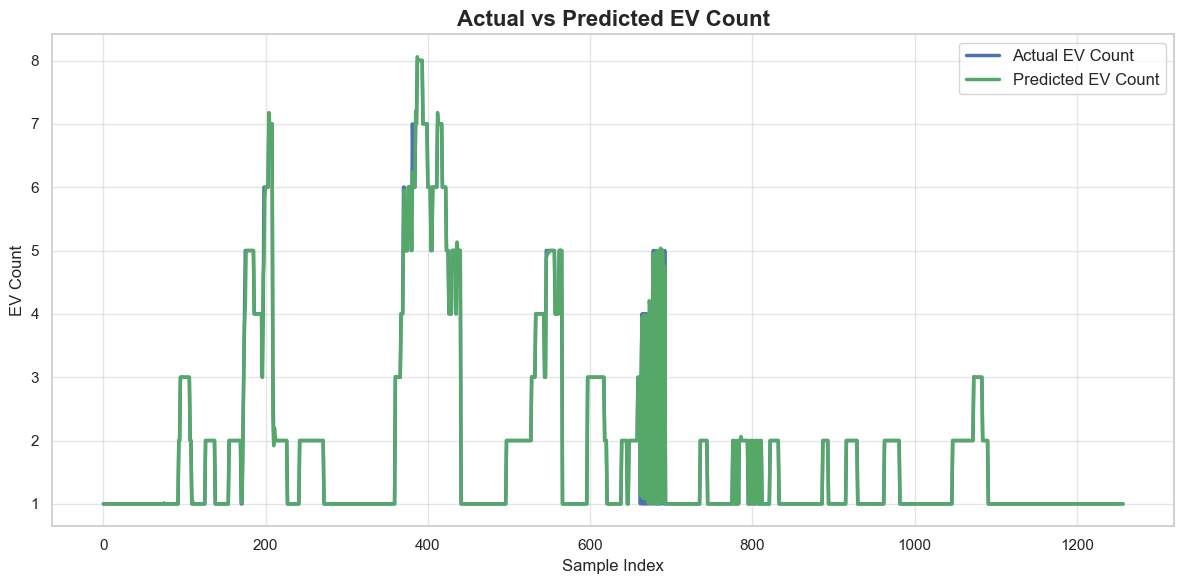

In [31]:
import seaborn as sns

# Evaluate model performance
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2Score = r2_score(y_true, y_pred)
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2 Score: {r2Score:.2f}")

evaluate(y_test, y_pred)

# Set seaborn style
sns.set(style="whitegrid")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual EV Count', color='#4C72B0', linewidth=2.5)
plt.plot(y_pred, label='Predicted EV Count', color='#55A868', linewidth=2.5)
plt.title("Actual vs Predicted EV Count", fontsize=16, fontweight='bold')
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("EV Count", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()


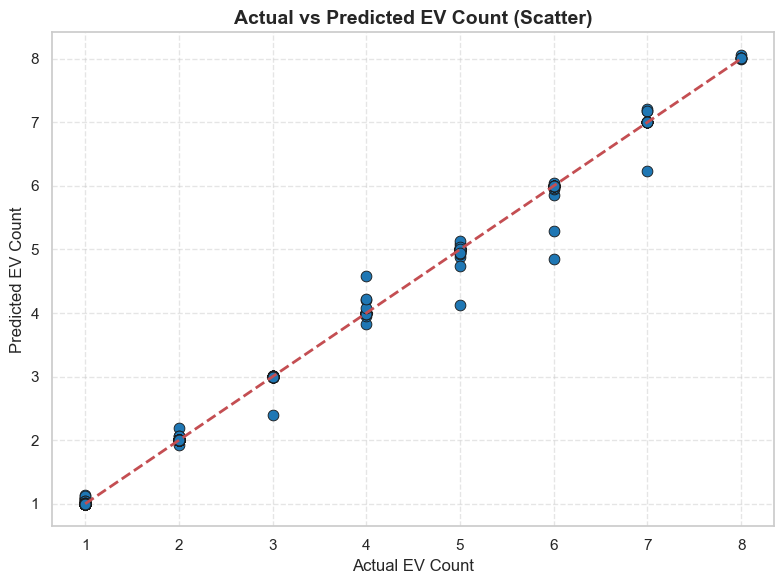

In [32]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='#1f77b4', edgecolor='k', s=60)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual EV Count", fontsize=12)
plt.ylabel("Predicted EV Count", fontsize=12)
plt.title("Actual vs Predicted EV Count (Scatter)", fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Get Feature Importance**

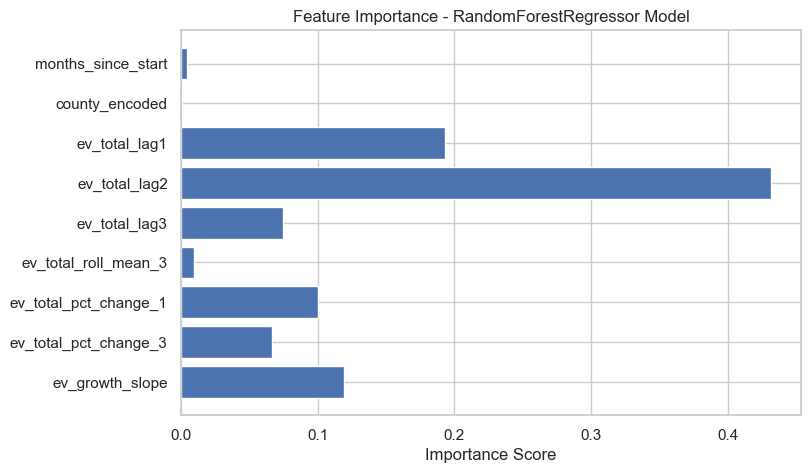

In [33]:
# Get feature importances from the trained RandomForest model
importances = model.feature_importances_

# Create horizontal bar plot of feature importances
plt.figure(figsize=(8, 5))
plt.barh(features, importances)
plt.xlabel('Importance Score')
plt.title('Feature Importance - RandomForestRegressor Model')
plt.gca().invert_yaxis()
plt.show()


**Feature Importance Summary**

The chart shows which features are most useful for predicting EV adoption.

 **Most important**: `ev_total_lag2`, `ev_total_lag1`, and `ev_growth_slope`  recent EV trends matter most.  
 **Moderate**: `ev_total_pct_change_1`, `ev_total_lag3`.  
 **Least**: `months_since_start`, `county_encoded`, and `ev_total_roll_mean_3`.

Past EV counts and growth trends are the key drivers in the model.


## Forecasting with Regression Model for Next 3 Years

Forecasting total eletric vehicles for a specific county (e.g., Clark)

In [34]:
# Define features and target
featuresX = ['County', 'county_encoded']

countyX = df[featuresX]

print("List of unique counties:")
print(df['County'].dropna().unique())

print("Total unique counties:", df['County'].nunique())

List of unique counties:
['Ada' 'Adams' 'Alameda' 'Albemarle' 'Alexandria' 'Allegheny' 'Allen'
 'Anchorage' 'Anne Arundel' 'Arapahoe' 'Arlington' 'Atlantic' 'Autauga'
 'Baltimore' 'Bartow' 'Beaufort' 'Bell' 'Bergen' 'Berkeley' 'Berkshire'
 'Bexar' 'Boone' 'Boulder' 'Bradley' 'Brevard' 'Broward' 'Bryan' 'Bucks'
 'Burlington' 'Caddo' 'Calvert' 'Camden' 'Canyon' 'Carroll' 'Carson City'
 'Cascade' 'Champaign' 'Charles' 'Charleston' 'Charlottesville'
 'Chesapeake' 'Clackamas' 'Clay' 'Clinton' 'Cobb' 'Cochise' 'Collier'
 'Collin' 'Columbia' 'Contra Costa' 'Cook' 'Coryell' 'Cumberland'
 'Currituck' 'Dakota' 'Dale' 'Dallas' 'Dane' 'Danville' 'DeKalb' 'Denton'
 'Denver' 'Deschutes' 'District of Columbia' 'Dorchester' 'Douglas'
 'DuPage' 'Duval' 'Eagle' 'Eau Claire' 'El Dorado' 'El Paso' 'Escambia'
 'Essex' 'Fairbanks North Star' 'Fairfax' 'Flathead' 'Fort Bend'
 'Franklin' 'Frederick' 'Fresno' 'Fulton' 'Galveston' 'Garfield' 'Geary'
 'Goochland' 'Greene' 'Guadalupe' 'Gwinnett' 'Hamilton' 'Hamps

In [35]:
#--- Data Preparation and Forecasting ---

# Set the county name and encode it
county = "Kings"
try:
    county_code = le.transform([county])[0]
except ValueError:
    print(f"Error: '{county}' not found.")
    exit()

# Filter data for the selected county
county_df = df[df['county_encoded'] == county_code].sort_values("numeric_date")
if county_df.empty:
    print(f"No data for county '{county}'.")
    exit()

# Extract recent EV data for forecasting
historical_ev = list(county_df['Electric Vehicle (EV) Total'].values[-6:])
cumulative_ev = list(np.cumsum(historical_ev))
months_since_start = county_df['months_since_start'].max()

# Historical data setup
historical = county_df[['year', 'month', 'numeric_date', 'Electric Vehicle (EV) Total', 'months_since_start']].copy()
historical['Source'] = 'Historical'
historical['Date'] = pd.to_datetime(historical[['year', 'month']].assign(day=1))

# Prepare for forecast
latest_row = county_df.iloc[-1].copy()
future_rows = []

for i in range(1, 37):  # Next 36 months
    next_date = pd.to_datetime(latest_row['year'] * 100 + latest_row['month'], format='%Y%m') + pd.DateOffset(months=1)
    y, m = next_date.year, next_date.month
    months_since_start += 1

    # Lag features
    lag1, lag2, lag3 = historical_ev[-1], historical_ev[-2], historical_ev[-3]
    roll_mean = np.mean([lag1, lag2, lag3])
    pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
    pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0

    # Slope of EV growth
    ev_growth_slope = np.polyfit(range(6), cumulative_ev[-6:], 1)[0] if len(cumulative_ev) >= 6 else 0

    # Build feature row
    new_row = {
        'months_since_start': months_since_start,
        'county_encoded': county_code,
        'ev_total_lag1': lag1,
        'ev_total_lag2': lag2,
        'ev_total_lag3': lag3,
        'ev_total_roll_mean_3': roll_mean,
        'ev_total_pct_change_1': pct_change_1,
        'ev_total_pct_change_3': pct_change_3,
        'ev_growth_slope': ev_growth_slope
    }

    # Predict EV value
    X_new = pd.DataFrame([new_row])[features]
    pred = model.predict(X_new)[0]
    new_row['Electric Vehicle (EV) Total'] = pred

    # Update rolling data
    historical_ev.append(pred)
    if len(historical_ev) > 6: historical_ev.pop(0)

    cumulative_ev.append(cumulative_ev[-1] + pred)
    if len(cumulative_ev) > 6: cumulative_ev.pop(0)

    # Add future row
    future_rows.append({
        'Date': next_date,
        'Electric Vehicle (EV) Total': pred,
        'months_since_start': months_since_start,
        'Source': 'Forecast'
    })

    latest_row['year'], latest_row['month'] = y, m

# Create forecast DataFrame
forecast_df = pd.DataFrame(future_rows)


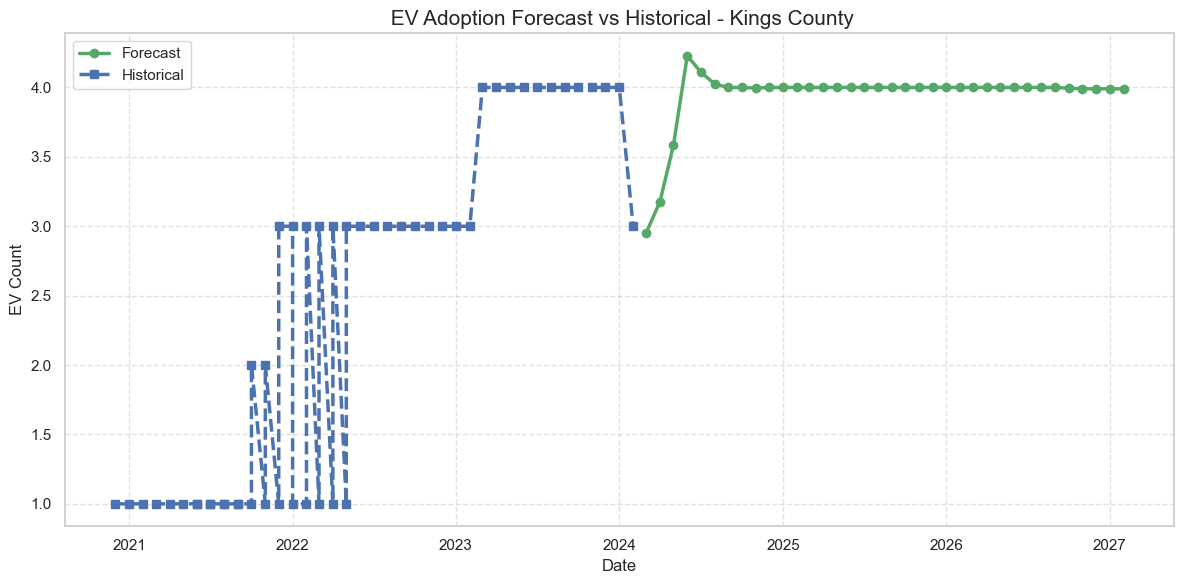

In [36]:
# --- Combine & Plot Historical + Forecasted Data ---

# Select needed historical columns
historical = historical[['Date', 'Electric Vehicle (EV) Total', 'months_since_start', 'Source']]

# Merge both DataFrames
combined = pd.concat([historical, forecast_df], ignore_index=True)

# Define colors for plot
colors = {'Historical': '#4C72B0', 'Forecast': '#55A868'}

# Plot
plt.figure(figsize=(12, 6))
for source, group in combined.groupby('Source'):
    plt.plot(group['Date'], group['Electric Vehicle (EV) Total'],
             label=source,
             marker='o' if source == 'Forecast' else 's',
             linestyle='-' if source == 'Forecast' else '--',
             color=colors[source],
             linewidth=2.5)

plt.title(f" EV Adoption Forecast vs Historical - {county} County", fontsize=15)
plt.xlabel("Date")
plt.ylabel("EV Count")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


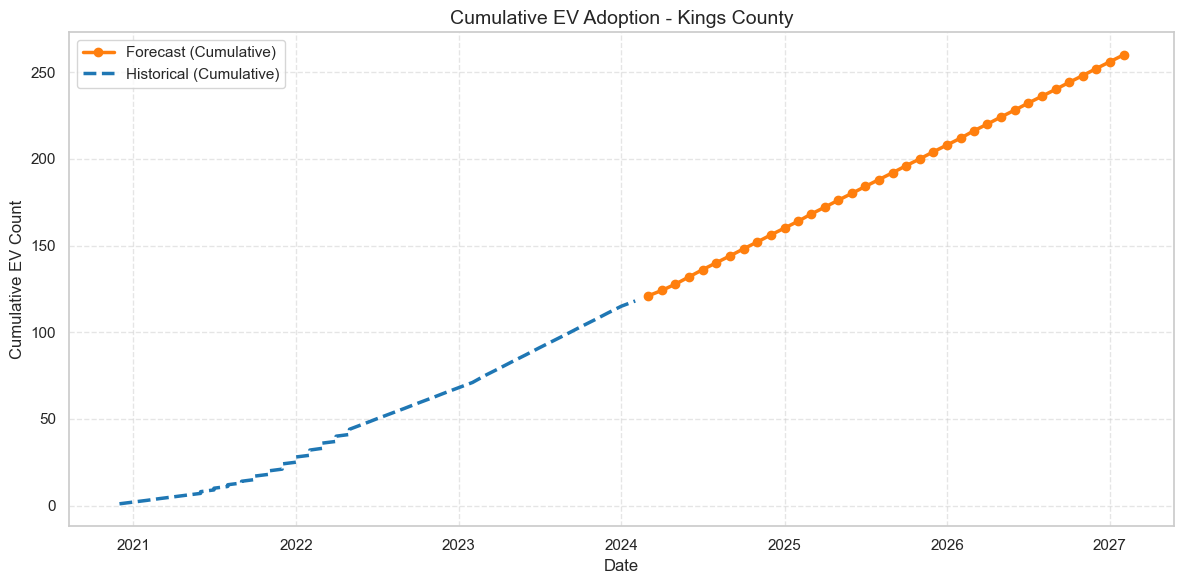

In [37]:
# Sort data by date
combined = combined.sort_values("Date")

# Calculate cumulative EV count
combined['Cumulative EVs'] = combined['Electric Vehicle (EV) Total'].cumsum()

# Set custom colors
colors = {
    'Historical': '#1f77b4',
    'Forecast': '#ff7f0e'
}

# Plot cumulative EV adoption
plt.figure(figsize=(12, 6))

for source, group in combined.groupby('Source'):
    plt.plot(
        group['Date'], group['Cumulative EVs'], label=f'{source} (Cumulative)',color=colors[source], linestyle='-' if source == 'Forecast' else '--',
        marker='o' if source == 'Forecast' else None,linewidth=2.5
    )

# Final plot settings
plt.title(f"Cumulative EV Adoption - {county} County", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Cumulative EV Count")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


**Kings County EV Adoption (2020–2027)**

From 2020 to 2023, Kings County saw steady and accelerating growth in EV adoption. The cumulative number of EVs increased consistently, showing strong acceptance among residents.

The forecast from 2024 to 2027 suggests continued linear growth, with the EV count potentially doubling by 2027.

This expected rise highlights the need for more EV infrastructure—such as charging stations and power grid upgrades—to support future demand.


**Forecasting for Top-5 Counties**

In [38]:
forecast_horizon = 36  # Forecast for 3 years (36 months)
all_combined = []
unique_counties = df['County'].dropna().unique()

for county in unique_counties:
    try:
        county_code = le.transform([county])[0]
    except ValueError:
        continue

    county_df = df[df['county_encoded'] == county_code].sort_values("numeric_date")
    if county_df.empty or county_df.shape[0] < 6:
        continue

    months_since_start = county_df['months_since_start'].max()

    historical = county_df[['Date', 'Electric Vehicle (EV) Total', 'months_since_start']].copy()
    historical['Source'] = 'Historical'
    historical['County'] = county

    historical_ev = list(county_df['Electric Vehicle (EV) Total'].values[-6:])
    cumulative_ev = list(np.cumsum(historical_ev))
    slope_history = []

    future_rows = []

    for _ in range(forecast_horizon):
        months_since_start += 1

        lag1, lag2, lag3 = historical_ev[-1], historical_ev[-2], historical_ev[-3]
        roll_mean = np.mean([lag1, lag2, lag3])
        pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
        pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0
        ev_growth_slope = np.polyfit(range(6), cumulative_ev[-6:], 1)[0] if len(cumulative_ev) >= 6 else 0

        new_row = {
            'months_since_start': months_since_start,
            'county_encoded': county_code,
            'ev_total_lag1': lag1,
            'ev_total_lag2': lag2,
            'ev_total_lag3': lag3,
            'ev_total_roll_mean_3': roll_mean,
            'ev_total_pct_change_1': pct_change_1,
            'ev_total_pct_change_3': pct_change_3,
            'ev_growth_slope': ev_growth_slope
        }

        X_new = pd.DataFrame([new_row])[features]
        pred = model.predict(X_new)[0]
        new_row['Electric Vehicle (EV) Total'] = pred

        forecast_date = historical['Date'].max() + pd.DateOffset(months=len(future_rows) + 1)
        future_rows.append({
            'Date': forecast_date,
            'Electric Vehicle (EV) Total': pred,
            'months_since_start': months_since_start,
            'County': county,
            'Source': 'Forecast'
        })

        historical_ev.append(pred)
        if len(historical_ev) > 6:
            historical_ev.pop(0)

        cumulative_ev.append(cumulative_ev[-1] + pred)
        if len(cumulative_ev) > 6:
            cumulative_ev.pop(0)

    forecast_df = pd.DataFrame(future_rows)
    combined = pd.concat([historical, forecast_df], ignore_index=True).sort_values("Date")
    combined['Cumulative EVs'] = combined['Electric Vehicle (EV) Total'].cumsum()

    all_combined.append(combined)

# Combine data for all counties
full_df = pd.concat(all_combined)


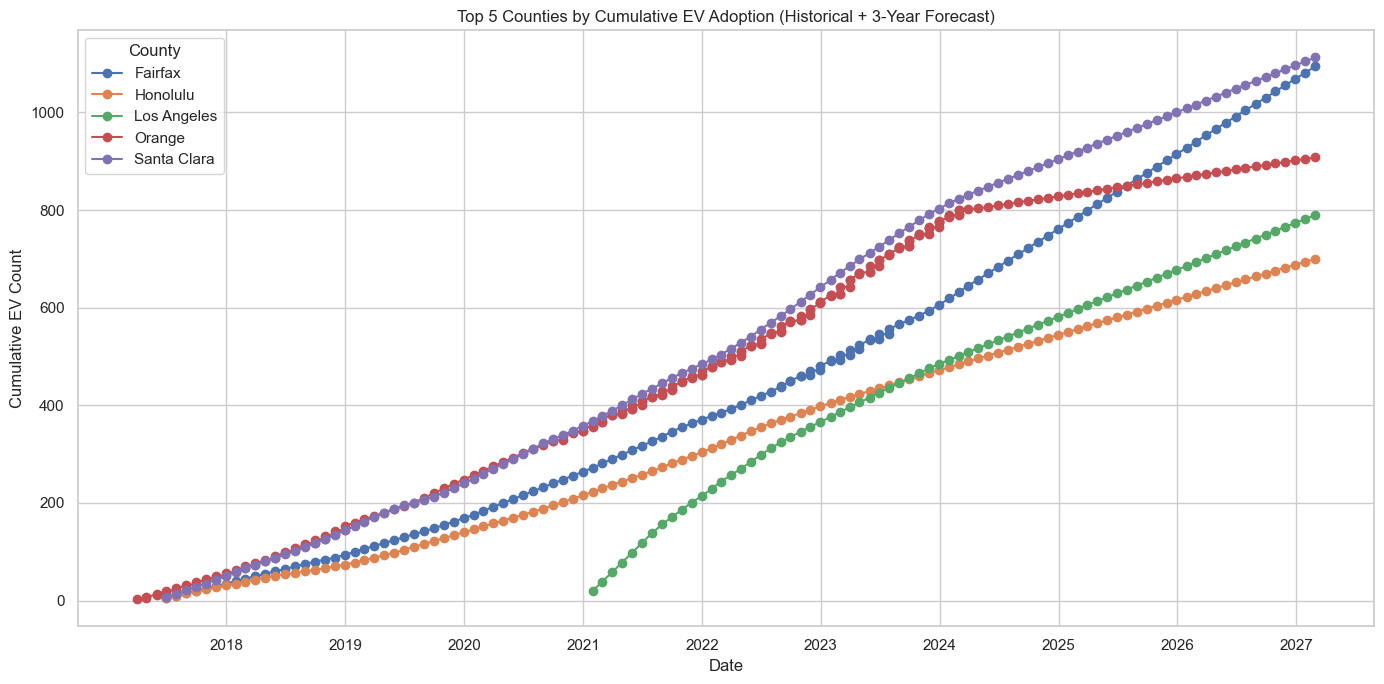

In [39]:
# Identify top 5 counties by final cumulative EVs
final_totals = full_df.groupby('County')['Cumulative EVs'].max().sort_values(ascending=False)
top_5_counties = final_totals.head(5).index.tolist()

# Filter data
top_5_df = full_df[full_df['County'].isin(top_5_counties)]

# Plot cumulative adoption
plt.figure(figsize=(14, 7))
for county, group in top_5_df.groupby('County'):
    plt.plot(group['Date'], group['Cumulative EVs'], label=county, marker='o')

# Customize plot
plt.title("Top 5 Counties by Cumulative EV Adoption (Historical + 3-Year Forecast)")
plt.xlabel("Date")
plt.ylabel("Cumulative EV Count")
plt.grid(True)
plt.legend(title="County")

# Format x-axis ticks
xticks = pd.date_range(start=top_5_df['Date'].min(), end=top_5_df['Date'].max(), freq='YS')
plt.xticks(ticks=xticks, labels=[str(d.year) for d in xticks], rotation=0)

plt.tight_layout()
plt.show()

**Summary: Top 5 Counties – Cumulative EV Adoption (2017–2027)**

The above graph compares historical and forecasted cumulative electric vehicle (EV) adoption across the top 5 U.S. counties.

**County-Wise Insights:**

- **🟣 Santa Clara**  
  ➤ Strongest and most consistent EV growth.  
  ➤ Continues leading through 2027.

- **🔵 Fairfax**  
  ➤ Fast acceleration in EV adoption.  
  ➤ Expected to surpass others around **2025**.

- **🔴 Orange**  
  ➤ Early rapid growth.  
  ➤ Forecast shows **flattening after 2024**.

- **🟠 Honolulu**  
  ➤ Steady but slower adoption.  
  ➤ Growth likely limited due to constraints.

- **🟢 Los Angeles**  
  ➤ Later start with sharp rise.  
  ➤ Growth continues, but **not as aggressive** as top two.


**Final Takeaway:**  
 **Santa Clara** and **Fairfax** are projected to **lead EV adoption** through 2027.  
 **Orange** may stagnate, while **Honolulu** and **L.A.** show steady, moderate growth — guiding regional EV infrastructure and policy planning.


In [40]:
# Save the trained model
import joblib

joblib.dump(model, 'forecasting_ev_model.pkl')
print("Model saved to 'forecasting_ev_model.pkl'")

Model saved to 'forecasting_ev_model.pkl'


## Final Model Testing and Save the Model

In [41]:
#Final Model Testing and Save the Model
import joblib

# Save the trained model to file
joblib.dump(model, 'forecasting_ev_model.pkl')
print("Model saved to 'forecasting_ev_model.pkl'")

Model saved to 'forecasting_ev_model.pkl'


In [42]:
# Load the saved model
loaded_model = joblib.load('forecasting_ev_model.pkl')
print("Model loaded successfully.")

Model loaded successfully.


In [43]:
# Test the saved model
sample = X_test.iloc[[0]]
true_value = y_test.iloc[0]
predicted_value = loaded_model.predict(sample)[0]

print("\nTesting saved model on 1 sample:")
print(f"Actual EVs: {true_value:.2f}, \nPredicted EVs: {predicted_value:.2f}")


Testing saved model on 1 sample:
Actual EVs: 1.00, 
Predicted EVs: 1.00
